#  Masking Pipeline

In [1]:
from chxanalys.chx_libs import np, roi, time, datetime, os,  getpass, db, get_images,LogNorm, plt,ManualMask

from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames,load_data, 
                                             RemoveHot, show_img, get_avg_img, reverse_updown)
 
%matplotlib notebook

/opt/conda_envs/analysis/lib/python3.5/site-packages/filestore/retrieve.py:15: UserWarning: Do not import filestore.retrieve, import filestore.api instead
  warnings.warn("Do not import filestore.retrieve, "
/opt/conda_envs/analysis/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Path for Saving Results

In [4]:
path = '/XF11ID/analysis/2016_3/masks/'
print ("The analysis results will be saved in : %s"%path)



The analysis results will be saved in : /XF11ID/analysis/2016_3/masks/


### Get the image series and metadata from the uid

In [6]:
uid = '05e27b' #count : 1 ['05e27b'] (scan num: 2968) (Measurement: CoralPor 1kHz 5k frames )

uid = 'eaed19'  #count : 1 ['eaed19'] (scan num: 3929) (Measurement: coralpor 750Hz 5k )  

uid = '6b07666f'

uid ='e368d5' #count : 1 ['e368d5'] (scan num: 4323) (Measurement: empty cell image for mask )

In [7]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  4323--e368d51a-4129-453d-8801-74dcaafd65e5--/XF11ID/data/2016/11/03/fb6004ec-f2b1-4c1b-b8c6_481


In [8]:
#imgs = load_data( uid, detector, reverse= True  )
imgs = load_data( uid, detector, reverse= False  )
md = imgs.md

hdf5 path = /XF11ID/data/2016/11/03/fb6004ec-f2b1-4c1b-b8c6_481_master.h5


In [9]:
imgs

<Frames>
Length: 1 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint32

In [10]:
Nimg=len(imgs)

In [11]:
md

{'beam_center_x': 1477.0,
 'beam_center_y': 786.0,
 'count_time': 0.1,
 'detector_distance': 4.8899999,
 'frame_time': 1.0,
 'incident_wavelength': 1.2848103,
 'pixel_mask': array([[0, 0, 0, ..., 0, 0, 4],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [12]:
#%matplotlib inline

In [13]:
 pixel_mask =  1- np.int_( np.array( md['pixel_mask'], dtype= bool)  )

In [14]:
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/Create_Report.py
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/chx_generic_functions.py

## show image and the pixel mask

<IPython.core.display.Javascript object>


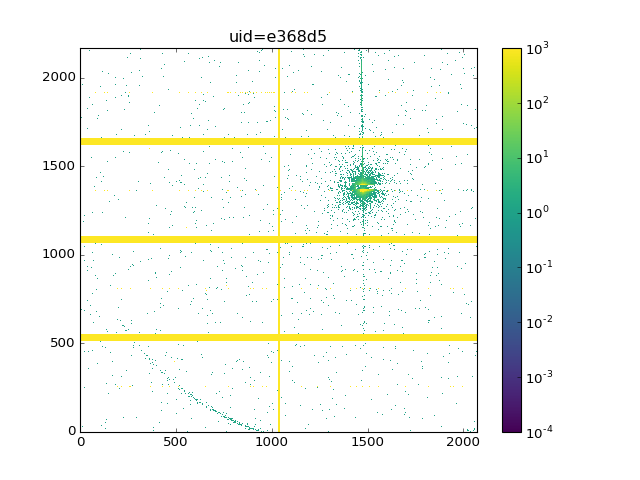

In [15]:
show_img(  imgs[0] , vmin=.0001, vmax=1000, logs=True, image_name ='uid=%s'%uid )

<IPython.core.display.Javascript object>


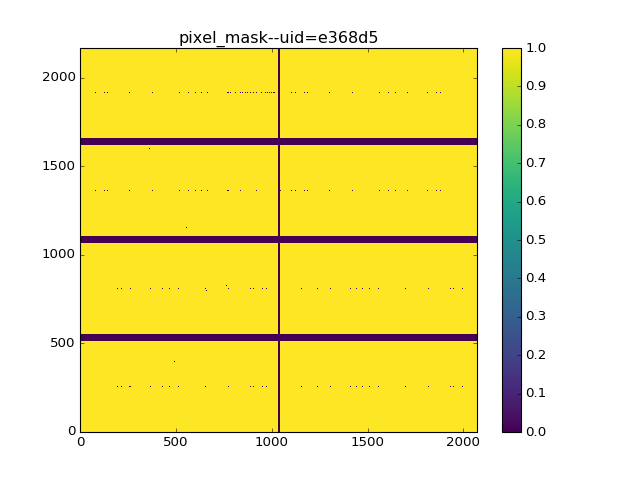

In [16]:
show_img(pixel_mask, vmin=0, vmax=1, image_name ='pixel_mask--uid=%s'%uid )

## Remove hotspots in the image

In [17]:
imgs.shape

(2167, 2070)

<IPython.core.display.Javascript object>


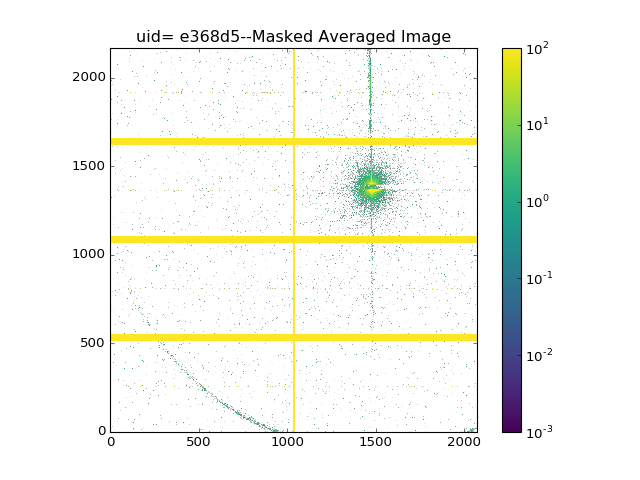

In [18]:
avg_img =  get_avg_img( imgs, sampling = 1000, plot_ = True, uid =uid)

In [124]:
#show_img(  avg_img*md['pixel_mask'],   vmin= .01, vmax= 100,
#         logs= True, aspect=1.,image_name ='img*pixel_mask--uid=%s'%uid )

In [125]:
#show_img(  avg_img*md['pixel_mask'],   vmin= 1, vmax= 1000,  aspect=1.,
#         
#         logs= True, image_name ='img*pixel_mask--uid=%s'%uid )

In [126]:
#show_img(  avg_img*md['pixel_mask'],   vmin= 1, vmax= 1000, xlim=[1000, 2070], ylim=[1000, 1500], aspect=1.,
#         
#         logs= True, image_name ='img*pixel_mask--uid=%s'%uid )

In [19]:
avg_img.shape

(2167, 2070)

In [20]:
2167-784

1383

<IPython.core.display.Javascript object>


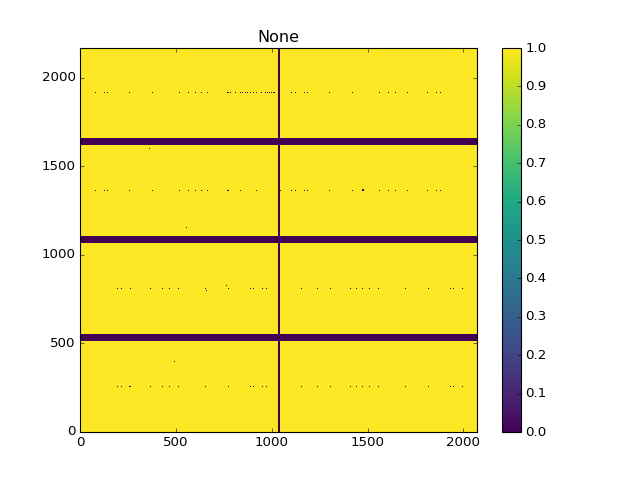

In [21]:
mask_rh  = RemoveHot( avg_img, 5E4, plot_=True)

## Manually create the mask file

<IPython.core.display.Javascript object>


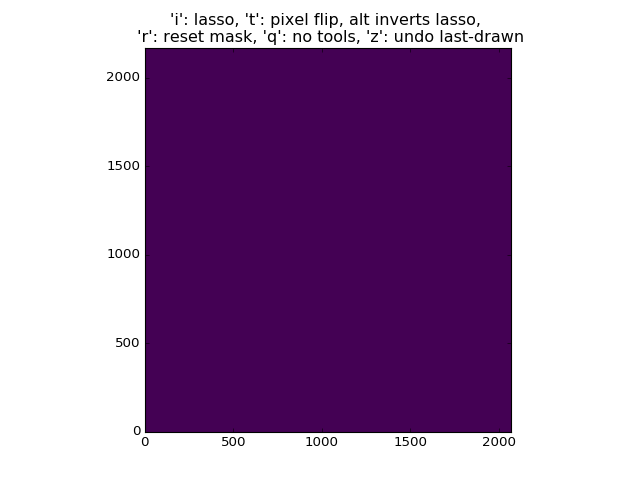

In [22]:
fig, ax = plt.subplots()
m = ManualMask(ax, avg_img* md['pixel_mask']*mask_rh,
               cmap='viridis',origin='lower',
               vmin=.01, vmax=1.50) 
plt.show()

<IPython.core.display.Javascript object>


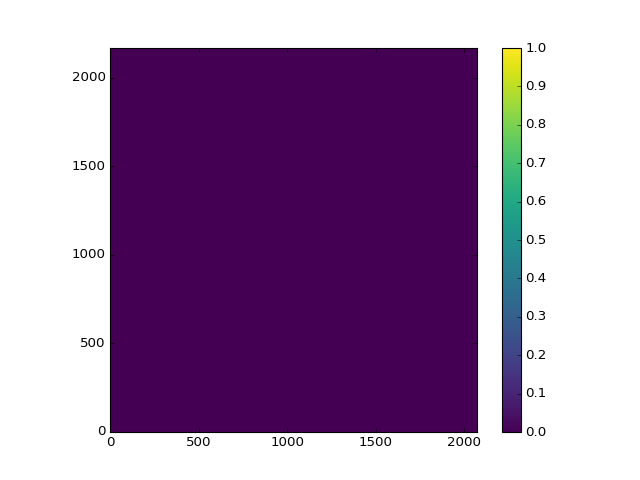

In [23]:
new_mask = m.mask
manu_mask  = new_mask.copy()
fig, ax = plt.subplots()
im=ax.imshow(new_mask,origin='lower' ,vmin=0, vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

In [24]:
manu_mask  = new_mask.copy()

# Create a polygon mask

In [25]:
from skimage.draw import line_aa, line, polygon, circle

### To create multi-rectangle masks, for each sub-mask,
* Make x= the coordinate-x of the four cornners (pay attention to the reserve image-xy to python-xy )
* Make y= the coordinate-y of the four cornners 

In [26]:
def create_cross_mask(  image, center, wy_left=4, wy_right=4, wx_up=4, wx_down=4,
                     center_circle = True, center_radius=10
                     ):
    '''
    Give image and the beam center to create a cross-shaped mask
    wy_left: the width of left h-line
    wy_right: the width of rigth h-line
    wx_up: the width of up v-line
    wx_down: the width of down v-line
    center_circle: if True, create a circle with center and center_radius
    
    Return:
    the cross mask
    '''
    imy, imx = image.shape   
    cx,cy = center
    bst_mask = np.zeros_like( image , dtype = bool)   
    ###
    #for right part    
    wy = wy_right
    x = np.array( [ cx, imx, imx, cx  ])  
    y = np.array( [ cy-wy, cy-wy, cy + wy, cy + wy])
    rr, cc = polygon( y,x)
    bst_mask[rr,cc] =1
    
    ###
    #for left part    
    wy = wy_left
    x = np.array( [0,  cx, cx,0  ])  
    y = np.array( [ cy-wy, cy-wy, cy + wy, cy + wy])
    rr, cc = polygon( y,x)
    bst_mask[rr,cc] =1    
    
    ###
    #for up part    
    wx = wx_up
    x = np.array( [ cx-wx, cx + wx, cx+wx, cx-wx  ])  
    y = np.array( [ cy, cy, imy, imy])
    rr, cc = polygon( y,x)
    bst_mask[rr,cc] =1    
    
    ###
    #for low part    
    wx = wx_down
    x = np.array( [ cx-wx, cx + wx, cx+wx, cx-wx  ])  
    y = np.array( [ 0,0, cy, cy])
    rr, cc = polygon( y,x)
    bst_mask[rr,cc] =1   
    
    rr, cc = circle( cy, cx, center_radius)
    bst_mask[rr,cc] =1   
    
    
    full_mask= ~bst_mask
    
    return full_mask
    
    

In [28]:
md

{'beam_center_x': 1477.0,
 'beam_center_y': 786.0,
 'count_time': 0.1,
 'detector_distance': 4.8899999,
 'frame_time': 1.0,
 'incident_wavelength': 1.2848103,
 'pixel_mask': array([[0, 0, 0, ..., 0, 0, 4],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

<IPython.core.display.Javascript object>


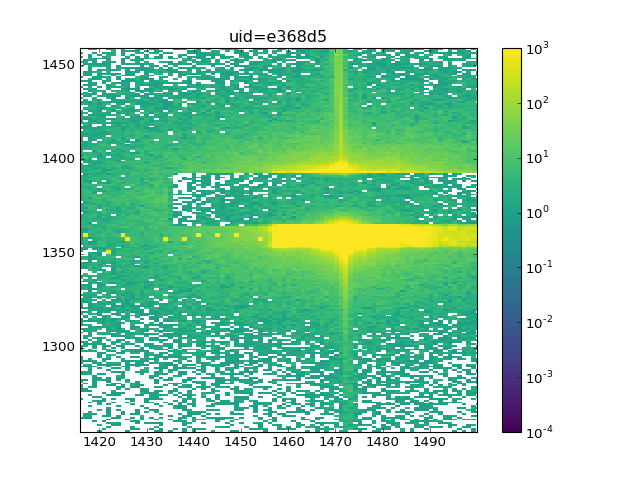

In [27]:
show_img(  imgs[0] , vmin=.0001, vmax=1000, logs=True, image_name ='uid=%s'%uid )

In [29]:
avg_img.shape

(2167, 2070)

In [30]:
2167-786

1381

In [46]:
full_mask = create_cross_mask(  avg_img, center=[ 1471, 1381],
                            wy_left=0, wy_right=20, 
                              wx_up= 14, wx_down= 10,center_radius= 54 )

<IPython.core.display.Javascript object>


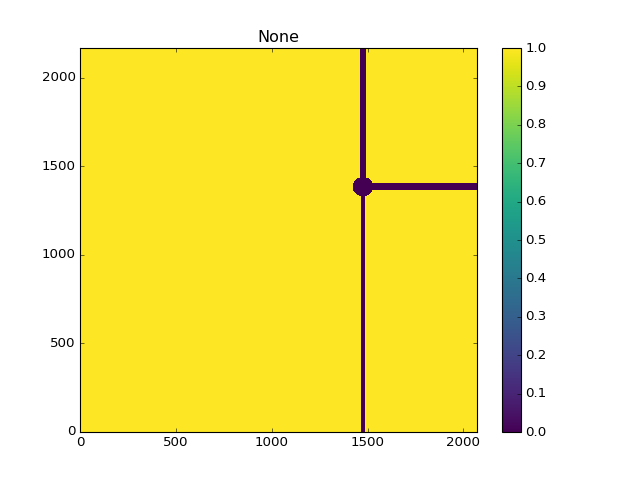

In [47]:
show_img( full_mask )

In [33]:
if False:#center of beam stop
    bst_mask = np.zeros_like( avg_img , dtype = bool)

    beam_center = [1381, 1471]

    ##h
    cx= 1750
    cy = 1380
    wx= 2070- cx
    wy = 20

    x = np.array( [ cx-wx, cx+wx, cx+wx, cx - wx,  ])  
    y = np.array( [ cy-wy, cy-wy, cy + wy, cy + wy])
    rr, cc = polygon( y,x)
    bst_mask[rr,cc] =1


    ##h
    cx= 1750
    cy = 1380
    wx= 2070- cx
    wy = 20

    x = np.array( [ cx-wx, cx+wx, cx+wx, cx - wx,  ])  
    y = np.array( [ cy-wy, cy-wy, cy + wy, cy + wy])
    rr, cc = polygon( y,x)
    bst_mask[rr,cc] =1





    #c=1381
    #w=5
    #bst_mask2 = np.zeros_like( avg_img , dtype = bool)
    #x = np.array( [ 0,    1340,   1340,     0])
    #y = np.array( [ c-w, c-w,  c+w,    c+w])
    #rr, cc = polygon( y,x)
    #bst_mask2[rr,cc] =1



    full_mask= ~bst_mask #* ~bst_mask2 *~bst_mask3 *~bst_mask4




In [138]:
#show_img(full_mask)

In [48]:
mask = np.array ( full_mask * pixel_mask*mask_rh  , dtype = bool )

<IPython.core.display.Javascript object>


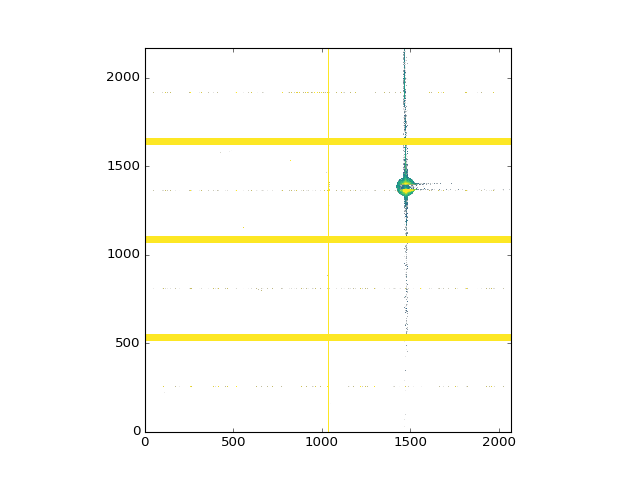

In [49]:
fig, ax = plt.subplots()
#new_mask = 
im=ax.imshow(   (~mask) * avg_img,origin='lower' , 
      norm= LogNorm( vmin=0.1, vmax= 1e2 ), cmap='viridis')
#im = ax.imshow(avg_img,  cmap='viridis',origin='lower', norm= LogNorm( vmin=0.001, vmax=100 ) )
plt.show()


<IPython.core.display.Javascript object>


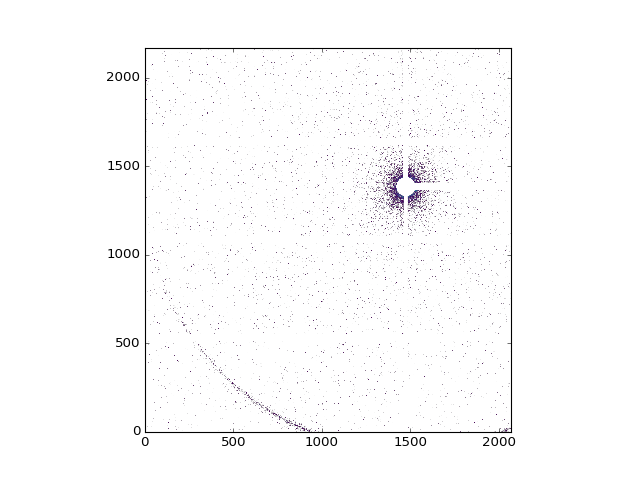

In [50]:
fig, ax = plt.subplots()
#new_mask = 
#im=ax.imshow(   (Mask) * avg_img,origin='lower' , 
#      norm= LogNorm( vmin=0.001, vmax=30 ), cmap='viridis')
#im = ax.imshow((mask)*avg_img,  cmap='viridis',origin='lower', norm= LogNorm( vmin=0.001, vmax=100 ) )
im = ax.imshow((mask)*avg_img,  cmap='viridis',origin='lower', norm= LogNorm( vmin=1, vmax=1000 ) )
plt.show()

## Combine the hand-drawn/polygon mask and the pixel mask and hot pixel mask

<IPython.core.display.Javascript object>


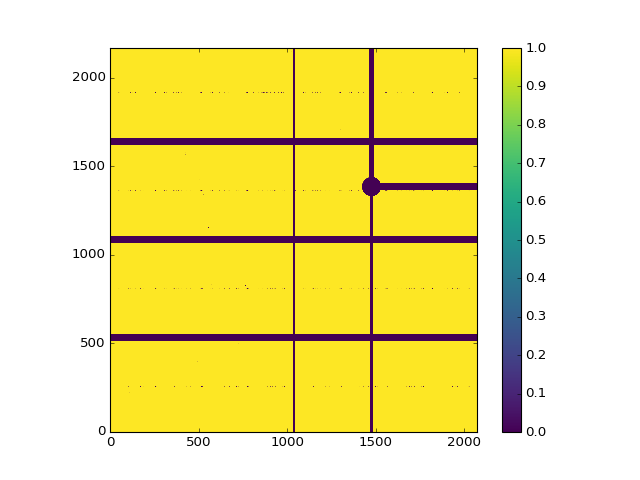

In [51]:
#mask = np.array ( ~new_mask* ~plgon_mask * md['pixel_mask']*mask_rh, dtype = bool )

fig, ax = plt.subplots()
im=ax.imshow(mask, origin='lower' ,vmin=0, vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Save the combined mask to use in further data analysis

In [52]:
np.save(  path +   uid +"_mask", mask)

In [245]:
#np.save(  path +   'July3' +"_mask", mask)

In [53]:
path +   uid +"_mask"

'/XF11ID/analysis/2016_3/masks/e368d5_mask'

In [55]:
#np.save(  path +   'Nov3_4M' +"_mask", mask)

In [147]:
#path +   'Octo28_4M' +"_mask"

In [40]:
#np.save(  path +   'Octo21_1M_pixel' +"_mask", md['pixel_mask'])